In [1]:
from pyspark.sql import SparkSession, functions
import pyspark
import matplotlib.pyplot as plt

In [2]:
NUMPARTITIONS = 4

In [4]:
# start spark session on spark-master node
spark_session = SparkSession.builder\
 .master("spark://192.168.2.197:7077") \
 .appName("Group13Project")\
 .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
 .config("spark.cores.max", 4)\
 .getOrCreate()

In [5]:
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

# 1 Preprocessing the data

In [6]:
lyrics = spark_context.textFile('hdfs://192.168.2.197:9000/mxm_dataset_train.txt',NUMPARTITIONS)
lyrics.take(18)

['# TRAINING SET',
 '# MusiXmatch dataset, the official lyrics dataset',
 '# of the Million Song Dataset',
 '#    file created on Tue Mar 29 04:28:44 2011',
 '#    contact: T. Bertin-Mahieux (Columbia University)',
 '#             tb2332@columbia.edu',
 '#    also: http://labrosa.ee.columbia.edu/millionsong/musixmatch',
 '#          http://www.musixmatch.com',
 '# FORMAT:',
 '#     #   - comment, to ignore',
 '#     %   - list of top words, comma-separated',
 '#         - normal line, contains track_id, mxm track id,',
 '#           then word count for each of the top words, comma-separated',
 '#           word count is in sparse format -> ...,<word idx>:<cnt>,...',
 '#           <word idx> starts at 1 (not zero!)',
 '# All our work is done using UTF-8 encoding.',
 '# enjoy!',
 '%i,the,you,to,and,a,me,it,not,in,my,is,of,your,that,do,on,are,we,am,will,all,for,no,be,have,love,so,know,this,but,with,what,just,when,like,now,que,time,can,come,de,there,go,up,oh,la,one,they,out,down,get,she,wa

In [7]:
lyrics.getNumPartitions()

4

As we can see, there are some problems regarding to the dataset structure: splitting the lyrics into lines is not a possible solution in the dataset for several reasons: <br />
* There are comments on the first lines we do not want to process.<br />
* The bag of words are on a single really long line.<br />
* Subsequent to the words, we have one line for each song in the format: TID,MXMID,idx:cnt,idx:cnt,... - track ID from MSD, track ID from musiXmatch,
then word index : word count (word index starts at 1!)<br />

Same goes for the song metadata.

## 1.1 Preprocessing the lyrics dataset

## 1.1.1 Remove comments
    

In [8]:
#%%timeit
lyricswithoutcomments = lyrics.filter(lambda x: not x[0].startswith('#'))
lyricswithoutcomments.take(10)

['%i,the,you,to,and,a,me,it,not,in,my,is,of,your,that,do,on,are,we,am,will,all,for,no,be,have,love,so,know,this,but,with,what,just,when,like,now,que,time,can,come,de,there,go,up,oh,la,one,they,out,down,get,she,was,see,if,got,never,from,he,feel,want,let,make,way,say,take,would,as,ca,day,at,babi,away,life,yeah,y,back,by,her,heart,here,how,could,night,need,our,look,where,en,eye,thing,world,more,caus,gonna,die,right,been,tell,think,un,who,el,through,man,live,again,give,too,onli,te,tri,tu,or,whi,se,keep,dream,well,mind,an,wo,still,us,his,long,mi,girl,wanna,find,fall,around,good,about,some,over,littl,turn,hand,then,noth,light,said,call,everi,alway,were,did,into,e,wait,leav,home,had,hold,run,es,walk,ever,them,lie,face,end,hear,gone,head,believ,everyth,ya,has,cri,alon,yo,hey,their,le,someth,si,insid,du,befor,o,word,stay,place,much,chang,ich,god,stand,these,better,last,friend,soul,anoth,je,left,new,him,than,stop,tonight,burn,sun,off,por,lo,play,thought,sing,show,lost,peopl,made,break,und,start,

## 1.1.2 Extract and flatten bag of words

In [9]:
#%%timeit
bagofwords = lyricswithoutcomments.filter(lambda x: not x[0].startswith('T'))
bagofwords.take(10)

['%i,the,you,to,and,a,me,it,not,in,my,is,of,your,that,do,on,are,we,am,will,all,for,no,be,have,love,so,know,this,but,with,what,just,when,like,now,que,time,can,come,de,there,go,up,oh,la,one,they,out,down,get,she,was,see,if,got,never,from,he,feel,want,let,make,way,say,take,would,as,ca,day,at,babi,away,life,yeah,y,back,by,her,heart,here,how,could,night,need,our,look,where,en,eye,thing,world,more,caus,gonna,die,right,been,tell,think,un,who,el,through,man,live,again,give,too,onli,te,tri,tu,or,whi,se,keep,dream,well,mind,an,wo,still,us,his,long,mi,girl,wanna,find,fall,around,good,about,some,over,littl,turn,hand,then,noth,light,said,call,everi,alway,were,did,into,e,wait,leav,home,had,hold,run,es,walk,ever,them,lie,face,end,hear,gone,head,believ,everyth,ya,has,cri,alon,yo,hey,their,le,someth,si,insid,du,befor,o,word,stay,place,much,chang,ich,god,stand,these,better,last,friend,soul,anoth,je,left,new,him,than,stop,tonight,burn,sun,off,por,lo,play,thought,sing,show,lost,peopl,made,break,und,start,

In [10]:
flatbagofwords = bagofwords.map(lambda x: x.split(',')).flatMap(lambda x: x).map(lambda s: s.replace("%",""))
flatbagofwords.take(10)

['i', 'the', 'you', 'to', 'and', 'a', 'me', 'it', 'not', 'in']

## 1.1.3 Count number of words
There should be the 5000 most popular words in the dataset.

In [11]:
flatbagofwords.count()

5000

## 1.1.4 Extract lyrics information about songs


In [12]:
songlyrics = lyricswithoutcomments.filter(lambda x: x[0].startswith('T'))
songlyrics.take(3)

['TRAAAAV128F421A322,4623710,1:6,2:4,3:2,4:2,5:5,6:3,7:1,8:1,11:1,12:2,13:3,14:1,15:1,18:2,19:2,20:2,21:2,23:4,25:1,26:2,28:1,30:1,36:2,42:1,45:1,54:2,56:1,57:1,68:1,99:1,192:2,249:1,264:1,356:1,389:1,561:1,639:1,656:1,687:1,761:1,773:1,804:1,869:2,914:1,1035:1,1156:1,1221:1,1287:1,1364:1,1407:1,1533:2,1857:1,2096:1,2117:1,2482:2,2548:1,2705:1,2723:1,2868:2,2992:2,3455:1,3717:1,3851:1,4322:1,4382:1,4613:1,4713:1,4906:1',
 'TRAAABD128F429CF47,6477168,1:10,3:17,4:8,5:2,6:2,7:1,8:3,9:2,10:3,11:4,12:3,14:7,15:5,16:5,18:6,23:4,24:1,26:6,28:2,29:5,31:3,33:3,35:2,39:3,40:1,43:5,47:7,52:2,57:3,58:2,61:2,62:2,68:2,71:4,74:2,76:4,81:5,84:2,86:3,87:2,88:2,89:2,92:2,101:1,107:1,111:2,113:1,118:3,119:2,130:3,131:3,165:1,168:1,169:2,178:4,180:2,188:2,196:7,200:1,219:2,229:2,256:1,279:2,349:4,384:1,393:2,424:2,472:3,589:1,843:2,1038:2,1351:1,1542:2,2437:2',
 'TRAAAED128E0783FAB,2516445,1:28,2:15,3:2,4:12,5:22,6:2,7:2,8:4,9:2,10:1,11:20,12:3,13:1,15:7,16:2,17:1,18:2,20:8,21:13,23:6,25:4,26:3,27:11,28:

In [13]:
songlyrics.count()

210519

Right now, the rdd entry consists of the trackid, the mxm id and a list in form of a long string that gives information on which word accurs how many times. In order to handle this information more easily, we want a single tuple to contain (trackid, wordid, number of ocurrences).

In [14]:
lyricstuples = songlyrics.map(lambda x: x.split(',')).map(lambda x: (x[0], x[1], x[2:-1]))
lyricstuples.take(1)

[('TRAAAAV128F421A322',
  '4623710',
  ['1:6',
   '2:4',
   '3:2',
   '4:2',
   '5:5',
   '6:3',
   '7:1',
   '8:1',
   '11:1',
   '12:2',
   '13:3',
   '14:1',
   '15:1',
   '18:2',
   '19:2',
   '20:2',
   '21:2',
   '23:4',
   '25:1',
   '26:2',
   '28:1',
   '30:1',
   '36:2',
   '42:1',
   '45:1',
   '54:2',
   '56:1',
   '57:1',
   '68:1',
   '99:1',
   '192:2',
   '249:1',
   '264:1',
   '356:1',
   '389:1',
   '561:1',
   '639:1',
   '656:1',
   '687:1',
   '761:1',
   '773:1',
   '804:1',
   '869:2',
   '914:1',
   '1035:1',
   '1156:1',
   '1221:1',
   '1287:1',
   '1364:1',
   '1407:1',
   '1533:2',
   '1857:1',
   '2096:1',
   '2117:1',
   '2482:2',
   '2548:1',
   '2705:1',
   '2723:1',
   '2868:2',
   '2992:2',
   '3455:1',
   '3717:1',
   '3851:1',
   '4322:1',
   '4382:1',
   '4613:1',
   '4713:1'])]

In [15]:
def maketuples(x):
    # extracts song x in format (trackid, mxmid, ['wordid:#occurences','...',...])
    # into (trackid, wordid, #occurences), ...
    trackid = x[0]
    tuples = []
    for i in range(0, len(x[2])):
        wordnumberlist = list((x[2][i]).split(':'))
        integertuple = (tuple([int(x) for x in wordnumberlist]))
        tuples.append((trackid, *integertuple))
    return tuples

In [16]:
wordtuples = lyricstuples.map(maketuples).flatMap(lambda x: x)
wordtuples.take(10)

[('TRAAAAV128F421A322', 1, 6),
 ('TRAAAAV128F421A322', 2, 4),
 ('TRAAAAV128F421A322', 3, 2),
 ('TRAAAAV128F421A322', 4, 2),
 ('TRAAAAV128F421A322', 5, 5),
 ('TRAAAAV128F421A322', 6, 3),
 ('TRAAAAV128F421A322', 7, 1),
 ('TRAAAAV128F421A322', 8, 1),
 ('TRAAAAV128F421A322', 11, 1),
 ('TRAAAAV128F421A322', 12, 2)]

In [17]:
wordtuples.count()

16635424

## 1.2 Preprocessing the song metadata dataset

In [18]:
songdata = spark_context.textFile('hdfs://192.168.2.197:9000/mxm_779k_matches.txt')
songdata.take(20)

['# musiXmatch dataset - list of matches',
 '#     matches provided by musiXmatch based on artist names',
 '#     and song titles from the Million Song Dataset.',
 '# MORE INFORMATION:',
 '#     http://labrosa.ee.columbia.edu/millionsong/musixmatch',
 '# FORMAT:',
 '#     #    -> comment, ignore',
 '#     tid|artist name|title|mxm tid|artist_name|title',
 '#        tid          -> Million Song Dataset track ID',
 '#        artist name  -> artist name in the MSD',
 '#        title        -> title in the MSD',
 '#        mxm tid      -> musiXmatch track ID',
 '#        artist name  -> artist name for mXm',
 '#        title        -> title for mXm',
 '#        |            -> actual separator: <SEP>',
 '# QUESTIONS / COMMENTS',
 '#     tb2332@columbia.edu',
 '# Enjoy!',
 'TRMMMKD128F425225D<SEP>Karkkiautomaatti<SEP>Tanssi vaan<SEP>4418550<SEP>Karkkiautomaatti<SEP>Tanssi vaan',
 'TRMMMRX128F93187D9<SEP>Hudson Mohawke<SEP>No One Could Ever<SEP>8898149<SEP>Hudson Mohawke<SEP>No One Could Eve

Again, we are having the same problems with comments. Now, within an entry the different categories are separated by a string.

## 1.2.1 Removing the comments

In [19]:
songdatawithoutcomments = songdata.filter(lambda x: not x[0].startswith('#'))
songdatawithoutcomments.take(3)

['TRMMMKD128F425225D<SEP>Karkkiautomaatti<SEP>Tanssi vaan<SEP>4418550<SEP>Karkkiautomaatti<SEP>Tanssi vaan',
 'TRMMMRX128F93187D9<SEP>Hudson Mohawke<SEP>No One Could Ever<SEP>8898149<SEP>Hudson Mohawke<SEP>No One Could Ever',
 'TRMMMCH128F425532C<SEP>Yerba Brava<SEP>Si Vos Querés<SEP>9239868<SEP>Yerba Brava<SEP>Si vos queres']

## 1.2.2 Separating the song metadata strings into tuples containing relevant information

In [20]:
def tupelizesongmetadata(x):
    songdatalist = x.split('<SEP>')
    return (songdatalist[0], songdatalist[1], songdatalist[2])

songdatatuples = songdatawithoutcomments.map(tupelizesongmetadata)
songdatatuples.take(3)

[('TRMMMKD128F425225D', 'Karkkiautomaatti', 'Tanssi vaan'),
 ('TRMMMRX128F93187D9', 'Hudson Mohawke', 'No One Could Ever'),
 ('TRMMMCH128F425532C', 'Yerba Brava', 'Si Vos Querés')]

# 2. Analysing the data

## 2.1 10 most popular words

In [21]:
zippedbagofwords = flatbagofwords.zipWithIndex()
zippedbagofwords.take(10)

[('i', 0),
 ('the', 1),
 ('you', 2),
 ('to', 3),
 ('and', 4),
 ('a', 5),
 ('me', 6),
 ('it', 7),
 ('not', 8),
 ('in', 9)]

In [22]:
# we want the index to start at 1 (in accordance to the dataset) 
# and we want to turn the tuples around ( -> (index, word))
indexedwords = zippedbagofwords.map(lambda x : (x[1]+1, x[0]))
indexedwords.take(10)

[(1, 'i'),
 (2, 'the'),
 (3, 'you'),
 (4, 'to'),
 (5, 'and'),
 (6, 'a'),
 (7, 'me'),
 (8, 'it'),
 (9, 'not'),
 (10, 'in')]

## 2.2 Total number of words counted by song
For each of the songs, we know if and how many times each of the 5000 most popular words are mentioned. Now, we are interested in how many words there are counted per song. There might be short songs with a little number of words or longer songs. 

In [23]:
numberofwordspersong = wordtuples.map(lambda x: (x[0], x[2])).reduceByKey(lambda x,y: x+y)
numberofwordspersong.take(10)

[('TRTLBQZ128F146A29C', 181),
 ('TRTLBRG128EF343C65', 323),
 ('TRTLBZP12903CF7271', 213),
 ('TRTLCFY128F148DE7D', 84),
 ('TRTLCUR12903CC50DE', 190),
 ('TRTLCYQ128F4264579', 284),
 ('TRTLCZK128F429110E', 137),
 ('TRTLDFZ128F423EA63', 156),
 ('TRTLDNS128F429E010', 279),
 ('TRTLDQG128F427E126', 453)]

In [24]:
# wanting to find out the names of the most generic songs, we need to join 
# the top 10 generic song ids with the metadata in the song
songdatadfcolumns = ['id', 'artist', 'title']
songdatadf = spark_session.createDataFrame(songdatatuples, songdatadfcolumns)

songdatadfcolumns = ['id', 'numberofwords']
numberofwordsdf = spark_session.createDataFrame(numberofwordspersong, songdatadfcolumns)

songdatadf.printSchema()
numberofwordsdf.printSchema()

root
 |-- id: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- title: string (nullable = true)

root
 |-- id: string (nullable = true)
 |-- numberofwords: long (nullable = true)



In [25]:
numberofwordssongdatadf = songdatadf.join(numberofwordsdf, 'id')
numberofwordssongdatadf.orderBy("numberofwords", ascending=False).show(10)

+------------------+--------------------+--------------------+-------------+
|                id|              artist|               title|numberofwords|
+------------------+--------------------+--------------------+-------------+
|TRDIEOU128F4261A22|Jessica Simpson f...|Woman In Me (feat...|         8568|
|TRVNYYP128F149293F|         The Misfits|Night Of The Livi...|         7277|
|TRGJCGR128F4261A8B|     Jessica Simpson|I've Got My Eyes ...|         5153|
|TRKRPTS12903CA72C8|             Big Moe| Freestyle (screwed)|         4525|
|TRYMLMM12903D05FD3|    Men Without Hats|        Safety Dance|         3421|
|TRTOVVZ12903CE3188|  The Sugarhill Gang|    Rapper's Delight|         3279|
|TRFMLVA128F4261870|     Jessica Simpson|Betcha She Don't ...|         3265|
|TRJVUJV128F4266767|     Jessica Simpson|I Think I'm In Lo...|         3188|
|TRTZJOL128F427C0A8|        Mariah Carey|   Always Be My Baby|         3051|
|TRYNOAJ128EF351A02|The Game feat. Ka...|The Whole City Be...|         2949|

## 2.3 Most generic songs
For each of the songs, we now have separate tuples over how often each the 5000 most popular words appear (if they appear). The tuples are in the form: (trackid, wordid, number of ocurrences of word). Our first task is to find the most generic songs. Here, we count the number of occurences weighted by the popularity of the first. Since word \#1 is the most popular and word \#5000 is the least popular, we turn the score around and give a weight of 5000 for every word \#1 that occurs, 4999 for \#2, ..., 1 for the least popular word. Since there might be some very long songs, we want to normalize by the number of words counted for each song. These numbers were computed in subtaks 2.1. 

In [26]:
weightedlyrics = wordtuples.map(lambda x: (x[0], (5001-x[1])*x[2])).reduceByKey(lambda x,y: x+y)
weightedlyricswithnumberofowords = weightedlyrics.join(numberofwordspersong)
weightedlyricswithnumberofowords.take(10)

[('TRMYKCW128F930C2A1', (551045, 118)),
 ('TRMYKKW128F422B207', (353572, 75)),
 ('TRMYKRP128F92E6EDC', (1307424, 271)),
 ('TRMYKWT128F930DF45', (1273034, 262)),
 ('TRMYLOD128F149543A', (496133, 103)),
 ('TRMYMKI128F9308D6B', (520158, 114)),
 ('TRMYMKU12903CA8A50', (868912, 178)),
 ('TRMYNIQ12903CE426E', (1005495, 223)),
 ('TRMYNMB128F4270201', (517812, 112)),
 ('TRMYNMY128F92F874C', (1087433, 229))]

In [27]:
normalizedgenericsongs = weightedlyricswithnumberofowords.map(lambda x: (x[0], x[1][0]/x[1][1])).sortBy(lambda x: x[1], False)
normalizedgenericsongs.take(10)

[('TRRQVQE12903D0A093', 5000.0),
 ('TRMLOGP128F930BE4A', 4999.5),
 ('TRMSHPF128E07889CE', 4999.5),
 ('TRIEBZY128F934B06A', 4999.0),
 ('TRCENCO128F4272C01', 4998.0),
 ('TRGBIRH128F4245FBF', 4996.0),
 ('TRRAWLU12903CB3E16', 4995.727272727273),
 ('TRVNFDC128F9339E16', 4995.2307692307695),
 ('TRLEIXL128F421BFF5', 4995.0),
 ('TRQKYBY128F4256880', 4995.0)]

In [28]:
genericsongcolumns = ['id', 'genericscore']
genericsongdf = spark_session.createDataFrame(normalizedgenericsongs, genericsongcolumns)

songdatadf.printSchema()
genericsongdf.printSchema()

root
 |-- id: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- title: string (nullable = true)

root
 |-- id: string (nullable = true)
 |-- genericscore: double (nullable = true)



In [29]:
genericsongdata = genericsongdf.join(songdatadf, 'id')

In [30]:
genericsongdata.orderBy("genericscore").show(10)

+------------------+------------------+--------------------+--------------------+
|                id|      genericscore|              artist|               title|
+------------------+------------------+--------------------+--------------------+
|TRMEHJL12903C98D05|1008.3333333333334|                Padi|     Menerobos Gelap|
|TRPVJAF128F423EB82|1320.7428571428572|       Natacha Atlas|           Dub Yalil|
|TRGWMNU12903CF423A|1352.6666666666667|                Padi|           Terlanjur|
|TRDCTXD128E07813EE|            1417.0|            Gorillaz|               Faust|
|TRLSTVS128F4255347|            1701.0|    Jenni Vartiainen|            Tunnoton|
|TRWZFMH12903CF4237|            1757.0|                Padi|          Demi Cinta|
|TRMHUER12903CF423E|            1757.0|                Padi|   Seperti Kekasihku|
|TRUSHJH128F425C407|            1844.5|            Karunesh|              Wu-Wei|
|TRVTCUG12903C96A20|            1894.0|                Padi|Kemana Angin Berh...|
|TRNGIDY12903CED

The method of computing the score for determining how generic a song is is of course a matter of debate. 

## 2.4 Distribution among the 100 most popular words

In [31]:
wordfrequency =  wordtuples.map(lambda x: (x[1], x[2])).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[0])

In [32]:
worddistribution = wordfrequency.join(indexedwords).sortBy(lambda x: x[0]).map(lambda x: x[1]).map(lambda x: (x[1], x[0]))
top100frequentwords = worddistribution.take(100)

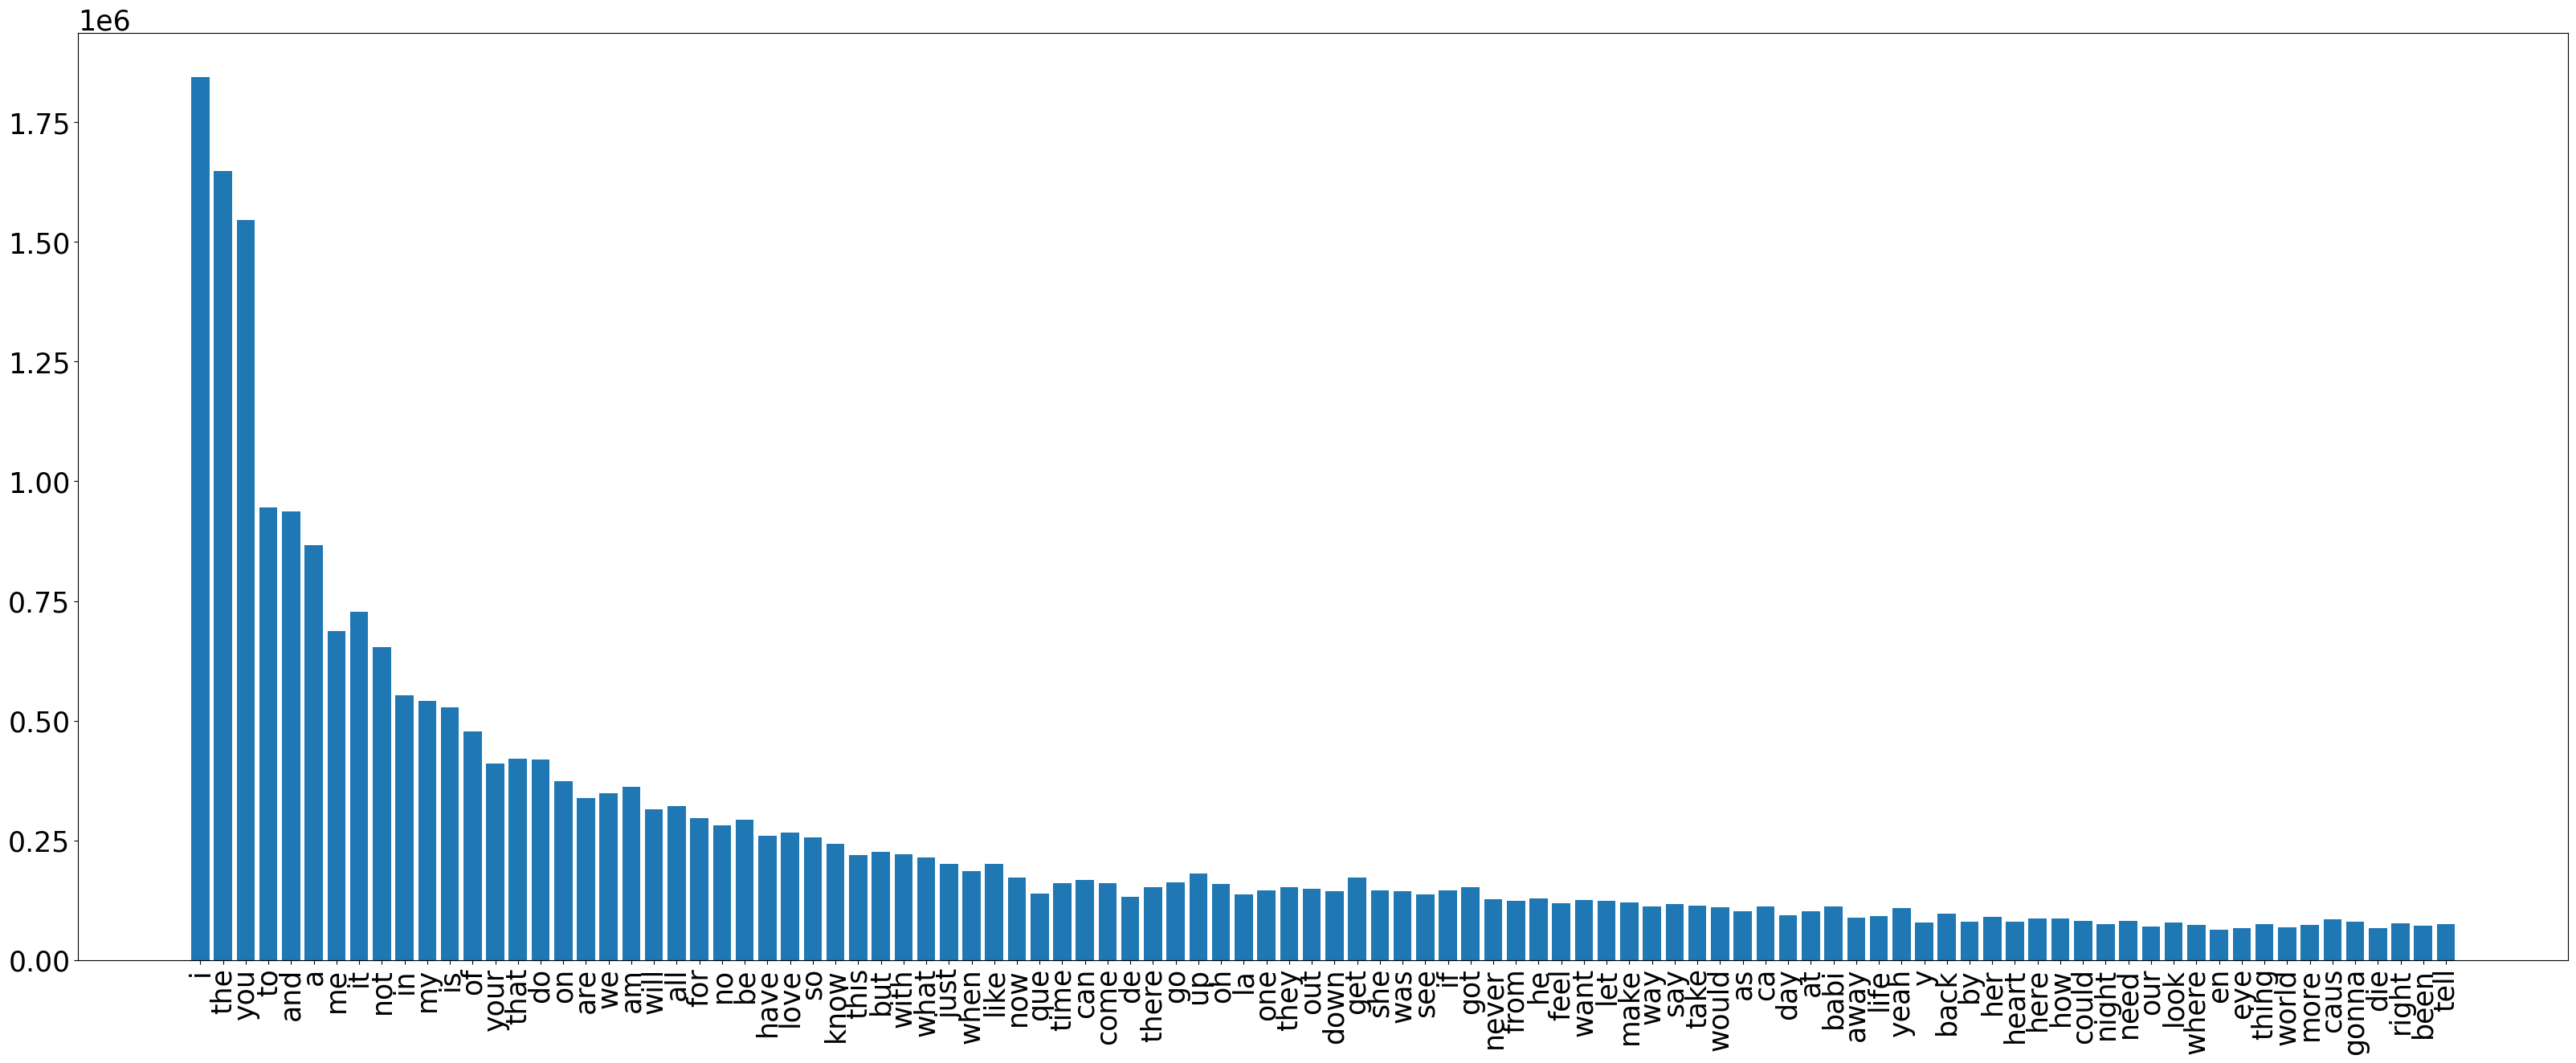

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(40, 15)
ax.bar(*zip(*top100frequentwords))
plt.xticks(rotation=90, fontsize=25);
plt.yticks(fontsize=25);
ax.yaxis.offsetText.set_fontsize(25)
plt.savefig('frequency_distribution.png')

In [34]:
spark_session.stop()